# Time series analysis with AI/ML

**Marc Buffat** dpt mécanique, UCB Lyon1

![time series](images/time_series.png)



In [1]:
import tensorflow as tf

2024-07-25 17:37:57.579635: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 17:37:57.625941: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 17:37:57.626707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 17:37:58.400407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# police des titres
plt.rc('font', family='serif', size='18')
from IPython.display import display,Markdown
# IA
import sklearn as sk
import tensorflow as tf

In [3]:
_uid_ = 12345
def serie_temp(N,a0=1.0,a1=0.5,a2 = 0.4, a3=0.1):
    # data / jours 
    np.random.seed(_uid_)
    # time series
    Ts = np.array([x for x in np.arange(N)],dtype=int)
    ys = [ a0*np.sin(2*np.pi*x/180) + a1*np.cos(2*np.pi*x/15) \
         + a2*x/360  for x in range(N)] + \
           a3*np.random.normal(size=N,scale=0.2)
    return Ts,ys

## Objectives 
We study a temporal system $Y(t)$ and aim to predict the evolution of the system, i.e., the forecast of its future realizations based on its past values.

A time series $Y(t)$ is commonly decomposed into trend, seasonality, and noise:

$$Y(t) =T(t)+S(t)+\epsilon(t)$$

- Trend $T(t)$ = long-term evolution
- Seasonality $S(t)$ = periodic phenomenon
- Noise $\epsilon(t)$ = random part


### Analysis methods

**Classical Methods** (linear time series modeling):

- Exponential smoothing
- Regression models (linear regression, non-parametric models, etc.)
- **ARIMA** models
  
  An Autoregressive Integrated Moving Average (ARIMA) model is a popular statistical method for analyzing and forecasting time series data. The ARIMA model is versatile and can be used to model both stationary and non-stationary time series by incorporating differencing
  
- **SARIMA** models

   A Seasonal Autoregressive Integrated Moving Average (SARIMA) model is a type of statistical model used to analyze and forecast time series data that exhibits seasonality. It extends the ARIMA model by explicitly incorporating both non-seasonal and seasonal components.

**Use of AI**:

- Random forest
- Recurrent neural networks (LSTM)



## Time series data-set

- time series $Y = Y(t)$
- N measurements at regular intervals $\Delta t$
    - data array `ys`
    
      $$ys[i] = Y(i\Delta t)$$
      
    - time array `ts` (for the analysis)
    
      $$ts[i] = i\Delta t$$
      
**test**
   
   1. simple periodic series
   2. bi-periodic series  (modulation)
   3. with long term trend
   4. with noise

In [4]:
# construction serie temporelle
# cas periodique le plus simple
Ts,ys = serie_temp(1000,a0=0,a1=0.5,a2=0.0,a3 = 0.)
# cas bi-periodique 
#Ts,ys = serie_temp(1000,a0=1.0,a1=0.5,a2=0.0,a3=0.0)
# + tendance 
#Ts,ys = serie_temp(1000,a0=1.0,a1=0.5,a2=0.2,a3=0.0)
# + bruit
Ts,ys = serie_temp(1000,a0=1.0,a1=0.5,a2=0.2,a3=0.3)

Text(0.5, 0, 'jour')

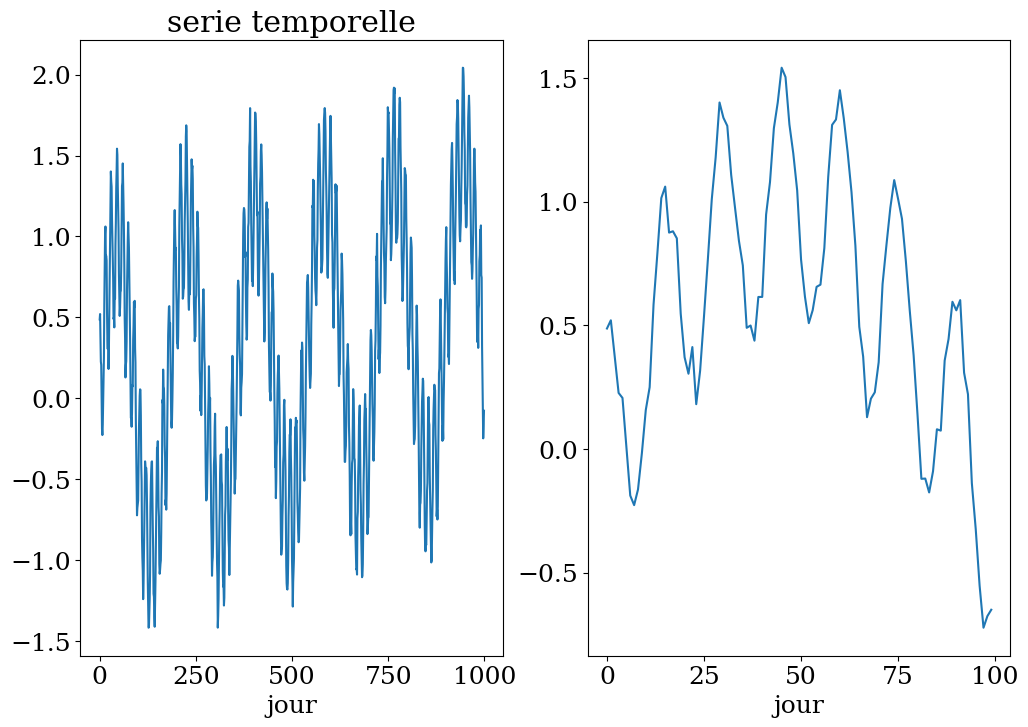

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(Ts[:],ys)
plt.xlabel("jour")
plt.title("serie temporelle");
plt.subplot(1,2,2)
plt.plot(Ts[:100],ys[:100])
plt.xlabel("jour")

## Data preparation

**Data Windowing:**

Choose a window of `nav` previous days to predict `nap` values (i.e., over the next `nap` days)

- `nav`: size of the history window (before)
- `nap`: size of the prediction window (after)
- `N`: number of windows
- `t0`: start date of prediction


In [6]:
def dataset(Ts,ys,nav,nap,N,t0):
    # choix d'une fenetre de nav jours précédents pour prédir nap valeurs (i.e. sur nap jours)
    # nav taille de la fenetre d'histoire (avant)
    # nap taille de la fenetre prediction (apres)
    # N nbre de fenetres
    # t0 date de debut prediction
    # 
    t1 = t0 - N - nav -nap
    print(f"apprentissage sur {N} fenetres de {nav}-{nap} jours entre le jour {t1} et {t0}")
    # 
    X  = np.zeros((N,nav))
    y  = np.zeros((N,nap))
    t  = np.zeros(N,dtype=int)
    # construction de la base de données
    for i in range(N):
        X[i,:] = ys[t1+i:t1+i+nav]
        y[i]   = ys[t1+i+nav:t1+i+nav+nap]
        t[i]   = Ts[t1+i+nav]
    return X,y,t

In [7]:
# N fenetres: de 14 jours -> 7 jours pour prediction à partir du jour t0
nav = 14
nap = 7
#N  = 200
#t0 = 300
N = 400
t0 = 600
X,y,t = dataset(Ts,ys,nav,nap,N,t0)

apprentissage sur 400 fenetres de 14-7 jours entre le jour 179 et 600


In [8]:
X.shape, y.shape, t.shape

((400, 14), (400, 7), (400,))

In [9]:
def plot_dataset():
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(t-nav,X[:,0])
    plt.plot(t,y[:,0])
    plt.xlabel("jour")
    plt.ylabel("y")
    plt.title("data apprentissage")
    plt.subplot(1,2,2)
    plt.plot(np.arange(t[0]-nav,t[0]+nap),ys[t[0]-nav:t[0]+nap],'--')
    plt.plot(np.arange(t[0]-nav,t[0]),X[0,:],'or')
    plt.plot(np.arange(t[0],t[0]+nap),y[0,:],'xg')
    plt.plot(np.arange(t[-1]-nav,t[-1]+nap),ys[t[-1]-nav:t[-1]+nap],'--')
    plt.plot(np.arange(t[-1]-nav,t[-1]),X[-1,:],'or')
    plt.plot(np.arange(t[-1],t[-1]+nap),y[-1,:],'xg')
    plt.xlabel("jour")
    plt.title("first/last window");
    return

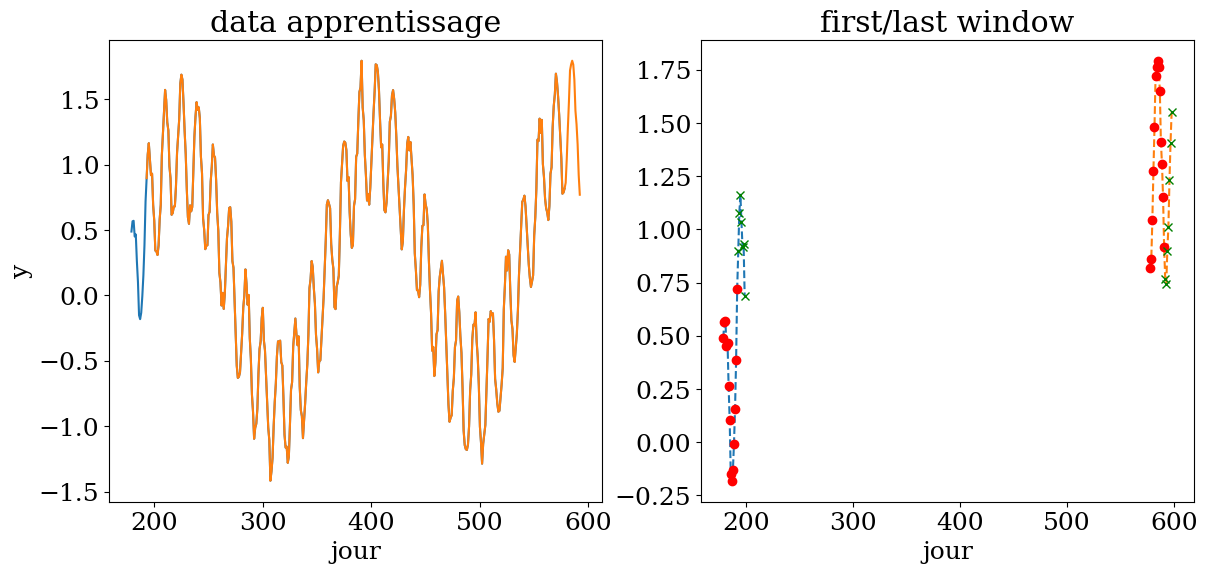

In [10]:
plot_dataset()

## Scikit Learn RandomForest

**"Random Forest" of Decision Trees**

- Prediction of one value at a time

![random forest](images/Random-forest.png)

## Neural Network: LSTM/RNN

**LSTM** = Long Short-Term Memory

- Recurrent neural network (RNN)
- Activation function: prevents output explosion (`tanh`)
- Numerical gradient method (learning rate $\alpha$:

  $$ w_{k+1} = w_k - \alpha F_w $$

- **EPOCH** = number of epochs for training

The number of epochs is an hyper-parameter that defines how many times the learning algorithm goes through the entire training dataset.


### Artificial Neuron Model
 
An artificial neuron is a fundamental unit in neural networks, designed to simulate the function of a biological neuron. Here's an overview of its key components and functionality:

<img src=images/neuroneformel-1.png width="600">

$$ y = f(\alpha_0 + \sum_i w_i x_i + b) $$

the output  $y$ is a non linear function of the inputs $\mathbf{x}$

**Components:**

1. **Inputs $\mathbf{x}$**:
   - Represents the features or signals fed into the neuron.
   - $\mathbf{x} = [x_1, x_2, \ldots, x_p]$

2. **Weights $\mathbf{w}$**:
   - Each input is multiplied by a weight that signifies its importance.
   - $\mathbf{w} = [w_1, w_2, \ldots, w_p]$

3. **Bias $\alpha_0$**:
   - An additional parameter added to the weighted sum of inputs.
   - It allows the model to fit the data better by shifting the activation function.

4. **Activation Function $f$**:
   - A function applied to the weighted sum of inputs and bias to produce the neuron's output.
   - Common functions include `sigmoid`, `tanh`, and `ReLU` (Rectified Linear Unit).

**Functionality:**

1. **Weighted Sum**:
   - Compute the linear combination of inputs and weights plus the bias.
   - $z = \mathbf{w} \cdot \mathbf{x} + \alpha_0 $
   - Where $z$ is the weighted sum.

2. **Activation**:
   - Apply the activation function to the weighted sum to get the output.
   - $ y = f(z) $
   - Where $y$ is the output of the neuron.

**Activation Functions:**

- **Sigmoid**: $f(z) = \frac{1}{1 + e^{-z}}$
- **Tanh**: $f(z) = \tanh(z) $
- **ReLU**: $f(z) = \max(0, z) $



### Artificial neuron model: learning phase 

In an artificial neuron model, the coefficients $w_i$ (weights) and $\alpha_0$ (bias) are obtained by minimizing an error function $ Err $ using a learning dataset. 

**Objective:**

The goal is to find the optimal values for the weights $w_i$ and the bias $\alpha_0$ that minimize the difference between the predicted output $\hat{y}$ and the actual target value $y_{pred}$. 

**Error Function:**

The error (or loss) function quantifies the discrepancy between the predicted values and the actual values. Commonly used error functions include:

- **Mean Squared Error (MSE)**: 

  $$ Err = \frac{1}{N} \sum_{i=1}^N (y_{pred,i} - \hat{y}_i)^2 $$
  
  where $N$ is the number of samples, $y_{pred,i}$ is the predicted value, and $\hat{y}_i$ is the actual value.

**Minimization of Error:**

To find the optimal weights $w_i$ and bias $\alpha_0$, the error function is minimized using optimization algorithms. These algorithms adjust the weights and bias to reduce the error. A popular optimization method is **gradient descent**.

**Gradient Descent:**

1. **Compute Gradient**:
   - Calculate the gradient of the error function with respect to each weight $w_i$ and the bias $\alpha_0$. 
   - The gradient gives the direction and magnitude of the steepest increase in error, so we move in the opposite direction to reduce the error.

2. **Update Weights and Bias**:
   - Adjust the weights and bias using the computed gradients and a learning rate $\beta$:

     $$w_i = w_i - \beta \frac{\partial Err}{\partial w_i}$$

     $$\alpha_0 = \alpha_0 - \beta \frac{\partial Err}{\partial \alpha_0}$$
     
   - Here, $\beta$ is the learning rate that controls the size of the steps taken in the direction of the negative gradient.

3. **Iterate**:
   - Repeat the gradient computation and weight/bias updates until the error function converges to a minimum or until a specified number of iterations is reached.

**Summary:**

In summary, the coefficients $w_i$ and $\alpha_0$ are optimized by minimizing the error function $Err$, which measures the difference between the predicted values $\hat{y}$ and the actual values $y_{pred}$. This is achieved through iterative optimization techniques such as gradient descent.

### Neural network
In neural networks, each layer is composed of multiple neurons that perform specific functions. 

<img src=images/reseau_neuronne.png width="600">

**Overview of different types of layers in a neural network** 

1. **Input Layer**

 - **Function**: Receives the raw data (features) from the data set.
 - **Characteristics**: Each neuron in the input layer corresponds to a feature in the data set. The number of neurons in this layer is equal to the number of features.

2. **Hidden Layers**

  Hidden layers are where the majority of the computations occur. They transform the inputs from the previous layer into something that can be used by the next layer. Each hidden layer consists of multiple neurons.

 - **Fully Connected (Dense) Layer**

    - **Function**: Each neuron is connected to every neuron in the previous layer.
    - **Activation**: Common activation functions include ReLU (Rectified Linear Unit), Sigmoid, or Tanh.
    - **Example**: In a dense layer with `n` neurons, each neuron receives inputs from all `p` neurons in the previous layer, applies weights and biases, and then passes the result through an activation function.

 - **Convolutional Layer**

    - **Function**: Applies convolutional operations to the input to detect local patterns such as edges in images.
    - **Characteristics**: Uses a set of filters or kernels that convolve over the input. Each filter produces a feature map, which is a transformed version of the input data.
    - **Activation**: Typically followed by activation functions like ReLU.

 - **Pooling Layer**

    - **Function**: Reduces the spatial dimensions (width and height) of the input, thereby reducing the number of parameters and computation.
    - **Types**: Common types include Max Pooling and Average Pooling.
    
     Max Pooling takes the maximum value in each patch of the feature map.

 - **Dropout Layer**

    - **Function**: Prevents overfitting by randomly setting a fraction of input units to zero during training.
    - **Characteristics**: Helps to ensure that the model does not rely too heavily on any one neuron or feature.

3. **Output Layer**

   - **Function**: Produces the final prediction or classification result.
   - **Characteristics**: The number of neurons in the output layer depends on the type of problem:
     - **Regression**: Typically one neuron with a linear activation function.
     - **Binary Classification**: One neuron with a sigmoid activation function.
     - **Multiclass Classification**: Multiple neurons (one per class) with a softmax activation function.


**Layer Connections:**

- **Dense Layer**: Each neuron in the hidden layer connects to every neuron in the input layer and each neuron in the output layer.
- **Convolutional Layer**: Applies a filter to local regions of the input, producing feature maps.
- **Pooling Layer**: Reduces the dimensions of the feature maps from the convolutional layer.

**Summary:**

In a neural network, each layer plays a distinct role in processing data. The input layer feeds data into the network, hidden layers transform and abstract features, and the output layer produces the final prediction. Layers can vary in function and complexity, such as convolutional layers for image data, recurrent layers for sequential data, and dropout layers to mitigate overfitting.

### Recurrent Neural Network RNN

**Recurrent Neural Networks (RNNs)** are a class of neural networks designed to handle sequential data, such as time series, natural language, or any other type of data where the order of the inputs is important. Unlike traditional feedforward neural networks, RNNs have connections that form directed cycles, allowing them to maintain a form of memory about previous inputs.

![images/Architecture-RNN.jpg](images/Architecture-RNN.jpg)

**Key Concepts**

1. **Sequential Data**:
   - RNNs are particularly useful for tasks where data points are not independent but rather dependent on previous points. For example, in language modeling, the prediction of the next word depends on the previous words.

2. **Hidden State**:
   - RNNs maintain a hidden state $h_t$ that captures information from previous time steps. This hidden state is updated at each time step and is used to influence the output and the state at the next time step.

**Architecture**

1. **Basic RNN Structure**:
   - **Input**: A sequence of data points $\{x_1, x_2, \ldots, x_T\}$, where $T$ is the length of the sequence.
   - **Hidden Layer**: At each time step $t$, the hidden state $h_t$ is updated based on the previous hidden state $h_{t-1}$ and the current input $x_t$:
     
     $$h_t = f(W_h h_{t-1} + W_x x_t + b_h)$$
     
     where $W_h$ is the weight matrix for the hidden state, $W_x$ is the weight matrix for the input, $b_h$ is the bias, and $f$ is an activation function (commonly $\tanh$ or `ReLU`).

   - **Output Layer**: The output $y_t$ at each time step can be computed from the hidden state:
     
     $$y_t = W_y h_t + b_y$$
     
     where $W_y$ is the weight matrix for the output and $b_y$ is the bias.

2. **Training**:
   - RNNs are trained using algorithms like **Backpropagation Through Time (BPTT)**, which extends backpropagation to handle the temporal dimension by unfolding the network over time.


### Problematic with the RNN

A simple classic recurrent neural network (RNN) consists of a recurrent layer followed by a dense (fully connected) layer. 

<img src="images/RNNsimple.png" width="200">

**Recurrent Neural Networks (RNNs)** involve a specific set of weight matrices and face particular challenges during training due to their recurrent nature.

**Weight Matrices in an RNN**

1. **Weight Matrix $W$**: 
   - This matrix is associated with the input layer and connects the input features to the hidden states.

2. **Recurrent Weight Matrix $R$**: 
   - This matrix connects the hidden state at the previous time step to the hidden state at the current time step. It captures the temporal dependencies in the sequence.

3. **Output Weight Matrix $V$**:
   - This matrix connects the hidden state to the output layer, producing the final predictions or outputs.

During training, the goal is to learn the optimal values for these three weight matrices ($W$, $R$, and $V$) using a set of labeled examples.

**Training Challenge with Gradient Descent**

- **Gradient Descent**:
  - The standard gradient descent algorithm for training neural networks is called backpropagation. It involves propagating the gradient of the error backward through the network layers, from the output layer to the input layer.

- **Issue with Cycles in RNNs**:
  - The presence of the recurrent weight matrix $R$ introduces cycles in the computation graph. When applying gradient descent, these cycles can lead to difficulties, such as:
    - **Vanishing Gradients**: Gradients may become exceedingly small as they are propagated back through many time steps, making it difficult for the network to learn long-term dependencies.
    - **Exploding Gradients**: Gradients can also become excessively large, leading to unstable training.

**Summary**

An RNN consists of three key weight matrices: \(W\) for the input layer, \(R\) for the recurrent connections, and \(V\) for the output layer. Training these networks involves learning these matrices using gradient descent. However, the recurrent nature of RNNs introduces cycles, complicating the backpropagation process. This issue is addressed through techniques like backpropagation through time (BPTT), though challenges such as vanishing and exploding gradients remain. Advanced architectures, such as LSTMs and GRUs, are often used to overcome these challenges and improve the performance of RNNs on sequential tasks.


### Back propagation Through Time (BPTT)

**Backpropagation Through Time (BPTT)**:
  - In the case of RNNs, this concept is extended to handle sequences. This approach, known as back propagation through time, involves unfolding the RNN through the time steps $K$ times ($K$ = number of internal hidden state from 2 to 100) and applying back propagation to this unfolded structure. See figure for $K=2$

<img src="images/RNNdeplie.png" width="200">

**BPTT with Cyclic Dependencies**:

- While BPTT is designed to handle the unfolding of RNNs, the recurrent connections can still present challenges. Proper implementation involves:
  - Carefully managing the unfolding process to ensure that the gradients are correctly propagated through the cycles.
  - Using techniques to mitigate the vanishing and exploding gradient problems, such as gradient clipping or using advanced RNN architectures like LSTM or GRU, which are designed to address these issues.

**Attention**

In Recurrent Neural Networks (RNNs), training challenges related to gradients are significant due to the nature of their architecture. Two main issues are particularly noteworthy: vanishing gradients and exploding gradients.

**Vanishing Gradients**

- **Issue**:
  - As RNNs are unfolded through time steps, they become very deep, creating a long chain of layers. This depth can lead to the vanishing gradient problem, where gradients become exceedingly small as they are back propagated through many time steps.
  - This problem makes it difficult for the network to learn long-term dependencies because the error signal diminishes as it propagates back through the network, especially affecting lower layers or earlier time steps.

- **Strategies to Mitigate Vanishing Gradients**:
  - **Batch Normalization**: This technique normalizes the inputs of each layer to improve the training speed and stability.
  - **Dropout**: Regularly dropping units (along with their connections) during training to prevent overfitting and make the network more robust.
  - **Regularization (L1 and L2)**: Adding regularization terms to the loss function to prevent overfitting and control the complexity of the model.
  - **Use of Advanced RNN Architectures**: Incorporating architectures like Long Short-Term Memory (LSTM) or Gated Recurrent Units (GRU) that are specifically designed to handle vanishing gradients by incorporating gating mechanisms that control the flow of information.

**Exploding Gradients**

- **Issue**:
  - Exploding gradients occur when the gradients become excessively large, leading to very large updates to the weights. This can destabilize the training process and lead to extremely high weights that make the model's performance erratic.

- **Solution**:
  - **Gradient Clipping**: This technique involves setting a threshold value for the gradient norm. If the norm of the gradient exceeds this threshold, it is scaled down to a predefined maximum value. This helps in preventing gradients from growing too large and causing instability.


### Advanced RNN Variants

To address the limitations of basic RNNs, several advanced architectures have been developed:

1. **Long Short-Term Memory (LSTM) Networks**:
   - **Architecture**: LSTMs introduce special units called memory cells that maintain information over long periods. They use gates (input, output, and forget gates) to control the flow of information into and out of the memory cells.
   - **Advantages**: LSTMs are effective at learning long-term dependencies and mitigating the vanishing gradient problem.

2. **Gated Recurrent Units (GRUs)**:
   - **Architecture**: GRUs are a simplified version of LSTMs with fewer gates. They use a reset gate and an update gate to control the flow of information.
   - **Advantages**: GRUs often perform similarly to LSTMs but with less computational complexity.


### LSTM : Long Short Term Memory

To model long-term dependencies, it is essential to enable Recurrent Neural Networks (RNNs) to maintain state over extended periods. This is the goal of Long Short-Term Memory (LSTM) cells, which are specifically designed to address this need.

LSTM cells are a type of RNN architecture that include mechanisms to preserve information over long sequences. 

<img src="images/RNN_LSTM.png" width="600">

**Key Components of LSTM Cells**

1. **Cell State (or Memory Cell)**:
   - The cell state is a crucial component of LSTM cells. It serves as a long-term memory that can retain information over many time steps. This state allows the network to maintain relevant information for extended periods, addressing the issue of vanishing gradients often encountered in standard RNNs.

2. **Gates**:
   - LSTM cells use gates to control the flow of information into and out of the cell state. These gates are learned during training and regulate how much of the past information should be remembered or forgotten.

   - **Forget Gate**:
     - The forget gate decides what portion of the previous cell state should be discarded. It uses a sigmoid activation function to output a value between 0 and 1, indicating how much of each component of the cell state should be kept or thrown away.

   - **Input Gate**:
     - The input gate determines how much of the new information should be added to the cell state. It also uses a sigmoid function to decide which values will be updated, combined with a tanh function to create candidate values that can be added to the cell state.

   - **Output Gate**:
     - The output gate controls the output of the cell state. It decides which parts of the cell state will be output to the next layer and uses a sigmoid function to filter this output, combined with a tanh function to adjust the values accordingly.

**How LSTM Cells Work**

1. **Update Cell State**:
   - At each time step, the forget gate decides which information from the previous cell state should be retained.
   - The input gate updates the cell state with new information based on the current input and the previous hidden state.
   - The cell state is updated accordingly, incorporating both retained and new information.

2. **Generate Output**:
   - The output gate processes the updated cell state and produces the final output of the LSTM cell. This output is used for predictions or fed into subsequent layers.

By incorporating these mechanisms, LSTM cells effectively manage long-term dependencies, allowing RNNs to maintain relevant information over many time steps and improving their performance on tasks requiring memory of past events.

**Summary**

LSTM cells are designed to address the limitations of traditional RNNs by providing a mechanism to maintain long-term dependencies. They do this through:

- A cell state (memory) that retains information over long periods.
- Gates (forget, input, and output) that regulate the flow of information into, out of, and within the cell state.

These features make LSTMs powerful for tasks involving sequences with long-term dependencies, such as language modeling, time series prediction, and more.

## Implementation and usage

### RandomForest algorithm

Python library 

   - **scikit learn** 

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics   import r2_score
# choix de l'algorithme
clf = RandomForestRegressor()
#clf = KNeighborsRegressor()
#clf = LinearRegression()
Xlearn = X.copy()
ylearn = y[:,0]
clf.fit(Xlearn,ylearn);

In [12]:
print("score = {:2d}%".format(int(100*clf.score(Xlearn, ylearn))))
yp = clf.predict(Xlearn)
print("R2 = {:3.2f}%".format(r2_score(ylearn,yp)))

score = 99%
R2 = 1.00%


In [13]:
def plot_pred():
    plt.figure(figsize=(10,6))
    plt.plot(Ts[t2:t2+nap],ypred,'x')
    plt.plot(Ts[t2-nav:t2],Xpred[0],'--o')
    plt.plot(Ts[t2-nav:t2+nap],ys[t2-nav:t2+nap],'--')
    plt.xlabel("jour")
    plt.title(f"prediction sur {nap} jours à partir du jour {t2}");
    return

In [14]:
# prediction à partir de t2
t2 = t0 
Xpred  = np.array([ys[t2-nav:t2]])
ypred  = np.zeros(nap)
Xp     = Xpred.copy()
ypred[0] = clf.predict(Xp)[0]
for i in range(1,nap):
    Xp[0,:-i] = Xpred[0,i:]
    Xp[0,-i:] = ypred[:i]
    ypred[i] = clf.predict(Xp)[0]
Xpred.shape, ypred.shape

((1, 14), (7,))

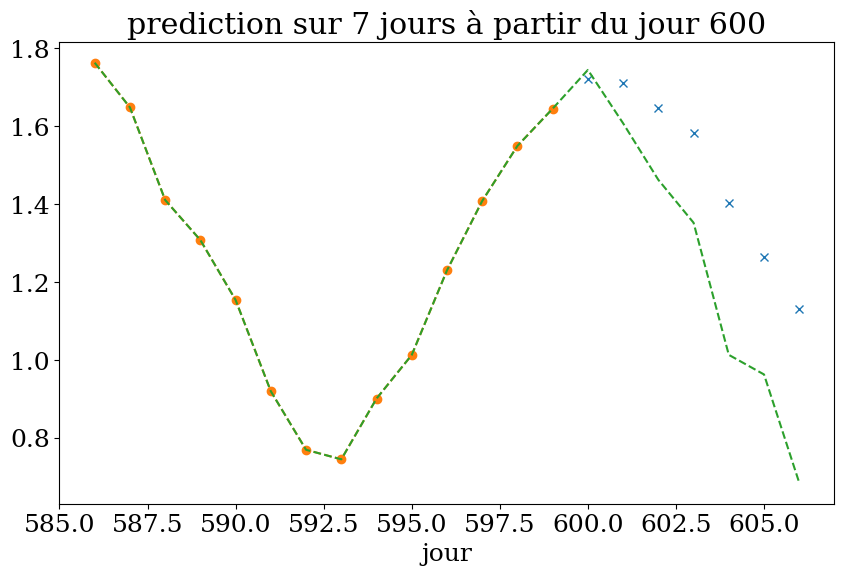

In [15]:
plot_pred()

### Implementation and usage of LSTM RNN

Python library KERAS

 - **tensor flow** Keras RNN

In [16]:
#Machine learning
from sklearn import preprocessing
import tensorflow as tf
import statsmodels as st
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection  import train_test_split

In [17]:
Xlearn = X.copy()
ylearn = y.copy()
Xlearn = Xlearn.reshape(X.shape[0], nav, 1)
ylearn = ylearn.reshape(y.shape[0], nap, 1)
Xlearn.shape, ylearn.shape

((400, 14, 1), (400, 7, 1))

In [18]:
#Nombre d'époque d'entrainement (fenetre de taille nav)
#EPOQUE = 300
EPOQUE = 200
#EPOQUE = 50
# modèle du réseaux de neurones(4 rangées (100,100,50,50) dont la première LSTM)
# si pas activation: activation='linear' lineaire a(x)=x, sinon test avec 'relu'
modele_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(nav),
    tf.keras.layers.Dense(nav,activation='tanh'),
    tf.keras.layers.Dense(nap,activation='tanh'),
    tf.keras.layers.Dense(nap)
])
#Configuration du modèle(on minimise avec la méthode des moindres carrés)
modele_lstm.compile(optimizer='adam', metrics=['mae'], loss='mse')
print(EPOQUE)

200


2024-07-25 17:38:15.891136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-25 17:38:15.892262: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
#Lance l'entrainement du modèle
import time
time_start = time.time()
modele_lstm.fit(Xlearn, ylearn, epochs=EPOQUE, verbose = False)
print('phase apprentissage: {:.2f} seconds'.format(time.time()-time_start))

2024-07-25 17:38:17.508765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 17:38:17.510446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 17:38:17.511649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

phase apprentissage: 10.40 seconds


In [20]:
modele_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14)                896       
                                                                 
 dense (Dense)               (None, 14)                210       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
Total params: 1,267
Trainable params: 1,267
Non-trainable params: 0
_________________________________________________________________


In [21]:
ypred = modele_lstm.predict(Xlearn, verbose=True)
print(Xlearn.shape,ypred.shape)
Ylearn = ylearn.reshape(ylearn.shape[0],nap,)
print("R2 score {:.2f}".format(r2_score(Ylearn, ypred)))
print("model evaluate loss/mae")
modele_lstm.evaluate(Xlearn,ylearn)

13/13 [==============================] - 0s 2ms/step


2024-07-25 17:38:31.719364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 17:38:31.721073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 17:38:31.722218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

(400, 14, 1) (400, 7)
R2 score 0.98
model evaluate loss/mae
13/13 [==============================] - 0s 2ms/step - loss: 0.0140 - mae: 0.0941


2024-07-25 17:38:32.093104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 17:38:32.095010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 17:38:32.096483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

[0.01402769610285759, 0.09413783997297287]

In [22]:
# prediction à partir de t2
t2 = t0 
Xpred  = np.array([ys[t2-nav:t2]]).reshape(1,nav,1)
ypred = modele_lstm.predict(Xpred, verbose=True)
print(Xpred.shape,ypred.shape)

1/1 [==============================] - 0s 19ms/step
(1, 14, 1) (1, 7)


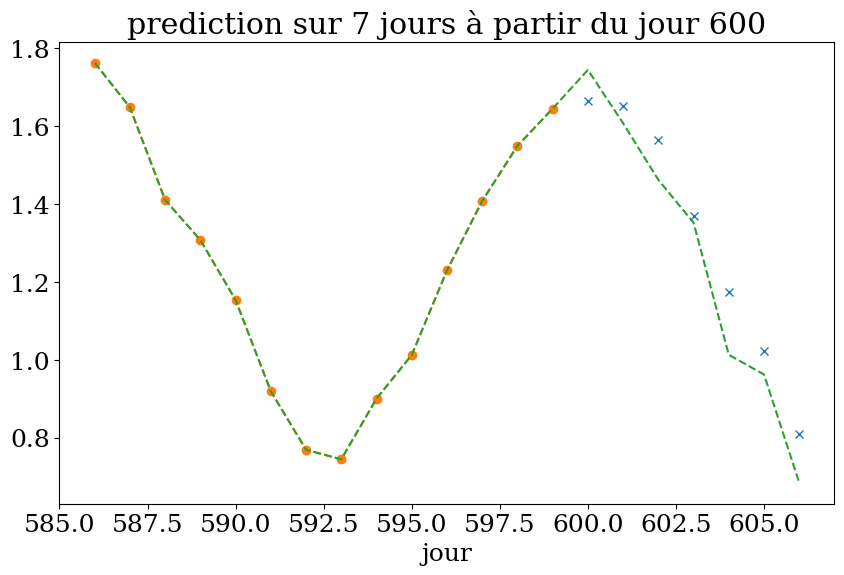

In [23]:
Xpred = Xpred.reshape(1,nav,)
ypred = ypred.reshape(nap)
plot_pred()